Using TensorFlow backend.


Train on 46166 samples, validate on 11542 samples
Epoch 1/5
46166/46166 [==============================] - 175s - loss: 0.0257 - val_loss: 0.0255
Epoch 2/5
46166/46166 [==============================] - 119s - loss: 0.0178 - val_loss: 0.0253
Epoch 3/5
46166/46166 [==============================] - 114s - loss: 0.0165 - val_loss: 0.0238
Epoch 4/5
46166/46166 [==============================] - 115s - loss: 0.0160 - val_loss: 0.0239
Epoch 5/5
46166/46166 [==============================] - 114s - loss: 0.0155 - val_loss: 0.0239
dict_keys(['loss', 'val_loss'])


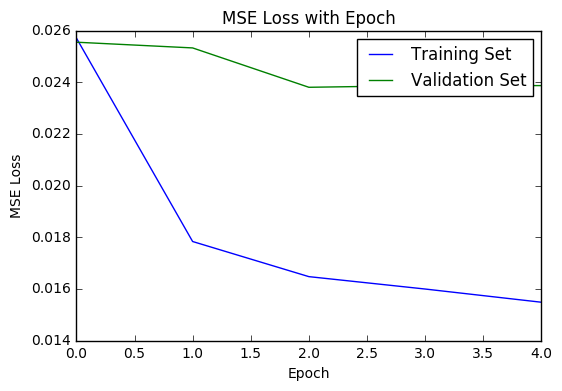

In [1]:
#----------------
#Import Modules 
#----------------
import csv
import cv2
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Convolution2D, Lambda, Cropping2D, Activation, Dropout
import matplotlib.pyplot as plt 

#-----------------------------
#Open Driving_log Data
#-----------------------------
Datas=[]
with open('./mydata/driving_log.csv') as csvfile:
    reader=csv.reader(csvfile)
    for data in reader:
        Datas.append(data)        

#----------------------------------------
#Data Augment : #1. Use Left/Right Images
#----------------------------------------
images=[]
angles=[]
correction=0.2
for Data in Datas:
    image_center=cv2.imread(Data[0])
    image_left=cv2.imread(Data[1])
    image_right=cv2.imread(Data[2])
    images.append(image_center)
    images.append(image_left)
    images.append(image_right)
    angle_center=float(Data[3])
    angle_left=angle_center+correction
    angle_right=angle_center-correction
    angles.append(angle_center)
    angles.append(angle_left)
    angles.append(angle_right)
    
#----------------------------------------
#Data Augment : #2. Image Flipping
#----------------------------------------
augmented_images=[]
augmented_angles=[]
for image,angle in zip(images, angles):
    augmented_images.append(image)
    augmented_angles.append(angle)
    augmented_images.append(cv2.flip(image,1))
    augmented_angles.append(angle*-1.0)

#----------------------------------------
#Preprocessed & Augmented Train Data
#----------------------------------------
X_train=np.array(augmented_images)
y_train=np.array(augmented_angles)

#------------------------------------------------
#My Model(Basically, Refer to Nvidia Model)
#To prevent overfitting, I reduced the # of layer
#(4 Convlayer, 3 FClyaer with Dropout(0.5))
#------------------------------------------------
model=Sequential()
#Data Normalization & Cropping
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((40,20),(0,0))))
#Layer#1. Convolution w/Dropout 0.5
model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
#layer#2. Convolution w/Dropout 0.5
model.add(Convolution2D(36, 5, 5, subsample=(2,2))) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
#layer#3. Convolution w/Dropout 0.5
model.add(Convolution2D(48, 5, 5, subsample=(2,2))) 
model.add(Activation('relu'))    
model.add(Dropout(0.5)) 
#layer#4. Convolution w/Dropout 0.5        
model.add(Convolution2D(64, 3, 3)) 
model.add(Activation('relu'))                   
model.add(Dropout(0.5))                        
#layer#5. Flatten 
model.add(Flatten()) 
#layer#6, FC w/Dropout 0.5 
model.add(Dense(1164)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
#layer#7, FC w/Dropout 0.5
model.add(Dense(100)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
#layer#8, FC w/Dropout 0.5 
model.add(Dense(10)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
#layer output 
model.add(Dense(1)) 

#--------------------------
#Training and saving Model
#--------------------------
model.compile(loss='mse',optimizer='adam')
history_object=model.fit(X_train,y_train,validation_split=0.2,shuffle=True, nb_epoch=5)

model.save('model.h5')  

#------------------
#MSE Visualization
#------------------

#Print the keys
print(history_object.history.keys())

#Plot the training & validation loss
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('MSE Loss with Epoch')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set','Validation Set'],loc='upper right')
plt.show()